# GTZAN_6_LightGBM
---

In [1]:
import numpy as np
import pandas as pd
import librosa
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, precision_score, recall_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from lightgbm import LGBMClassifier

# Read in file

In [2]:
# read in file
filepath = '../gtzan/own_csv/df_noduplicates.csv'
df_3 = pd.read_csv(filepath, index_col=0)

# drop columns: 'filename', 'length' 
df_3.drop(columns=['filename', 'length'], inplace=True)

print(df_3.shape)
df_3.head(3)

(9847, 58)


,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues


# Set target, predictors, standardization

In [3]:
# set target and features
X = df_3.copy()
y = X.pop('label')

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

# # standardscaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns, index=X_test.index)

# Baseline
y_test.value_counts(normalize=True)

blues        0.101523
classical    0.101523
jazz         0.101523
country      0.101015
disco        0.100508
rock         0.100508
reggae       0.100000
pop          0.099492
hiphop       0.099492
metal        0.094416
Name: label, dtype: float64

# PCA (all features)

In [50]:
# PCA (n_components: 0.9999)
n_components = 0.9999
pca = PCA(n_components=n_components, random_state=1, svd_solver='full')
X_train_pc = pd.DataFrame(pca.fit_transform(X_train), 
                         columns=[f'PC_{i+1}' for i in range(pca.n_components_)], index=X_train.index)

X_test_pc = pd.DataFrame(pca.transform(X_test), 
                         columns=[f'PC_{i+1}' for i in range(pca.n_components_)], index=X_test.index)

display(X_train_pc.head(3))
print(pca.explained_variance_ratio_.cumsum())

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_47,PC_48,PC_49,PC_50,PC_51,PC_52,PC_53,PC_54,PC_55,PC_56
6535,-5.273166,-6.167187,1.345471,1.123555,-0.603370,0.771625,0.755719,-1.004752,-0.159771,-0.063493,...,0.121074,-0.019945,0.445561,0.271364,-0.479309,-0.523248,0.187016,0.103133,-0.100394,0.014560
625,-0.515342,1.813487,4.630386,1.915605,1.681363,0.436591,-2.147151,-0.577363,-0.365986,-0.371310,...,0.064622,0.632422,0.140321,0.062738,0.381988,0.037552,-0.210541,-0.120403,-0.048747,-0.000290
1949,-1.794878,2.274721,3.316637,3.989158,-2.708549,1.932897,3.609233,2.383106,-3.494039,4.396239,...,0.203891,0.191172,-0.026600,0.886325,0.137341,-0.311034,0.018842,-0.080876,-0.192847,-0.346759


[0.19693593 0.33277709 0.43657312 0.50294066 0.54678617 0.58377001
 0.61335998 0.64023907 0.6654956  0.68693547 0.70569705 0.72351818
 0.74058495 0.75561978 0.76921124 0.78091766 0.79207139 0.8028624
 0.81266499 0.82197806 0.8307666  0.8393097  0.84764316 0.85579663
 0.86365234 0.8712389  0.8787581  0.88603821 0.89305122 0.89996235
 0.90665321 0.91317655 0.91945846 0.92558516 0.93161825 0.93740046
 0.94281321 0.94806709 0.95306707 0.95768618 0.96227398 0.96674103
 0.97104055 0.97518641 0.97913969 0.98283504 0.9863513  0.98951242
 0.99244916 0.99497769 0.99679816 0.99807571 0.99902133 0.99959884
 0.99980932 0.99994241]


# LightGBM (original features)

In [21]:
lgb_nonstd = LGBMClassifier()
lgb_nonstd.fit(X_train, y_train)

# scores
print('cv mean:\t', cross_val_score(lgb_nonstd, X_train, y_train, cv=5).mean())
print('train score:\t', lgb_nonstd.score(X_train, y_train))
print('test score:\t', lgb_nonstd.score(X_test, y_test))

cv mean:	 0.8950099911368946
train score:	 1.0
test score:	 0.9091370558375634


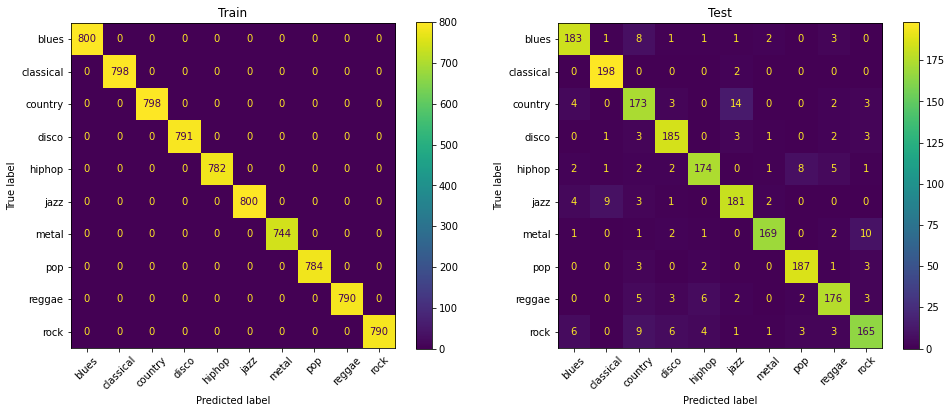

In [22]:
# confusion matrix
pred_train = lgb_nonstd.predict(X_train)
pred_test = lgb_nonstd.predict(X_test)
conf_matrix = confusion_matrix(y_train, pred_train)
#display(conf_matrix)

# plot confusion matrix
fig, ax = plt.subplots(1,2, figsize=(16,6))
plot_confusion_matrix(lgb_nonstd, X_train, y_train, ax=ax[0], xticks_rotation=45)
plot_confusion_matrix(lgb_nonstd, X_test, y_test, ax=ax[1], xticks_rotation=45)
ax[0].set_title('Train')
ax[1].set_title('Test')
plt.show()

In [23]:
lgb_nonstd.feature_importances_

array([ 775,  466,  545,  886,  347,  298,  742,  400,  267,  449,  539,
        226, 1055,  844, 1559, 1230,  653,  612,  590,  504,  261,  887,
        612, 1102,  423,  576,  478,  813,  435,  774,  379,  671,  304,
        807,  273,  558,  348,  649,  207,  551,  243,  548,  208,  483,
        222,  433,  232,  491,  209,  525,  178,  474,  190,  397,  295,
        467,  310], dtype=int32)

In [9]:
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)

# scores
print('cv mean:\t', cross_val_score(lgb, X_train, y_train, cv=5).mean())
print('train score:\t', lgb.score(X_train, y_train))
print('test score:\t', lgb.score(X_test, y_test))

cv mean:	 0.8961529288534364
train score:	 1.0
test score:	 0.9045685279187817


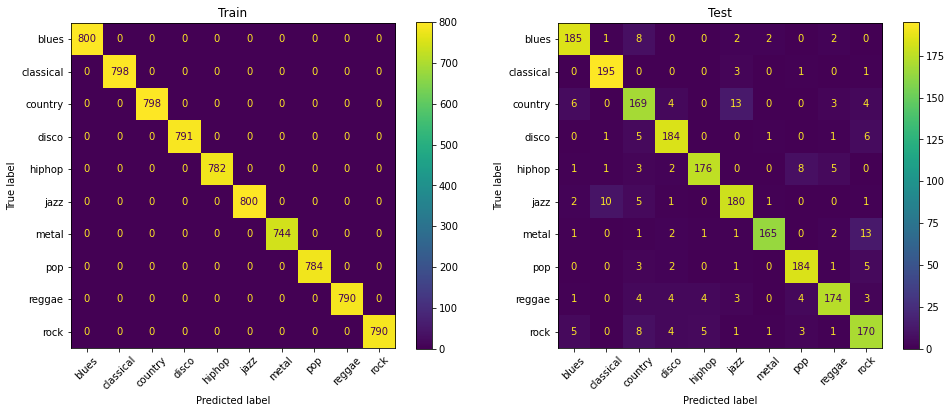

In [12]:
# confusion matrix
pred_train = lgb.predict(X_train)
pred_test = lgb.predict(X_test)
conf_matrix = confusion_matrix(y_train, pred_train)
#display(conf_matrix)

# plot confusion matrix
fig, ax = plt.subplots(1,2, figsize=(16,6))
plot_confusion_matrix(lgb, X_train, y_train, ax=ax[0], xticks_rotation=45)
plot_confusion_matrix(lgb, X_test, y_test, ax=ax[1], xticks_rotation=45)
ax[0].set_title('Train')
ax[1].set_title('Test')
plt.show()

In [17]:
lgb.feature_importances_

array([ 780,  440,  564,  907,  372,  294,  754,  389,  305,  426,  539,
        221, 1059,  808, 1564, 1217,  654,  609,  567,  501,  272,  864,
        604, 1087,  419,  627,  456,  804,  435,  785,  349,  686,  295,
        795,  291,  566,  349,  696,  225,  560,  254,  530,  213,  457,
        194,  413,  218,  490,  188,  570,  168,  479,  212,  399,  276,
        466,  338], dtype=int32)

# Gridsearch LightGBM (original features)

In [27]:
lgb_forgrid = LGBMClassifier()

param_grid = {
#     boosting_type='gbdt',
    'num_leaves':[10,31,50],
    'max_depth':[10,50,500,-1],
    'learning_rate':[0.001,0.01,0.1],
    'n_estimators':[50,100,1000],
#     subsample_for_bin=200000,
#     objective=None,
    'class_weight':['balanced', None],
#     min_split_gain=0.0,
#     min_child_weight=0.001,
#     min_child_samples=20,
#     subsample=1.0,
#     subsample_freq=0,
#     colsample_bytree=1.0,
#     reg_alpha=0.0,
#     reg_lambda=0.0,
    'random_state':[1],
    'n_jobs':[-1],
#     silent=True,
#     importance_type='split'    
}

grid = GridSearchCV(estimator=lgb_forgrid, param_grid=param_grid, n_jobs=-1, cv=5, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 37.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 63.5min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 87.2min finished


GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [10, 50, 500, -1],
                         'n_estimators': [50, 100, 1000], 'n_jobs': [-1],
                         'num_leaves': [10, 31, 50], 'random_state': [1]},
             verbose=1)

In [30]:
# scores
print('best params:\t', grid.best_params_)
print()
print('cv mean:\t', grid.best_score_)
print('train score:\t', grid.score(X_train, y_train))
print('test score:\t', grid.score(X_test, y_test))

best params:	 {'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000, 'n_jobs': -1, 'num_leaves': 10, 'random_state': 1}

cv mean:	 0.9106244460559181
train score:	 1.0
test score:	 0.9203045685279188


In [31]:
# pickle model
filename = 'grid_lgbm.pkl'
pickle.dump(grid, open(filename, 'wb'))

In [7]:
# read in model
filename = 'grid_lgbm.pkl'
grid_lgb = pickle.load(open(filename, 'rb'))

In [8]:
grid_lgb.best_params_

{'class_weight': 'balanced',
 'learning_rate': 0.1,
 'max_depth': 10,
 'n_estimators': 1000,
 'n_jobs': -1,
 'num_leaves': 10,
 'random_state': 1}

In [11]:
lgb = LGBMClassifier(class_weight='balanced', learning_rate=0.1, max_depth=10, n_estimators=1000, n_jobs=-1, num_leaves=10, random_state=1)
lgb.fit(X_train, y_train)

# scores
print('cv mean:\t', cross_val_score(lgb, X_train, y_train, cv=5).mean())
print('train score:\t', lgb.score(X_train, y_train))
print('test score:\t', lgb.score(X_test, y_test))

cv mean:	 0.9087199258722102
train score:	 1.0
test score:	 0.9131979695431472


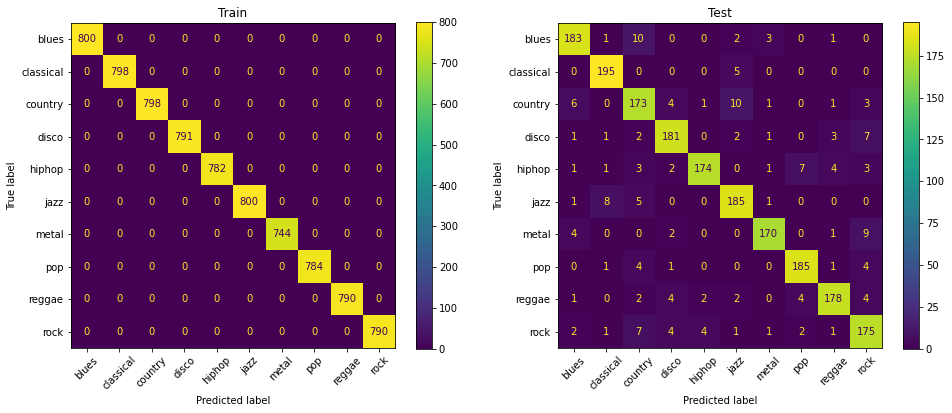

In [12]:
# confusion matrix
pred_train = lgb.predict(X_train)
pred_test = lgb.predict(X_test)
conf_matrix = confusion_matrix(y_train, pred_train)
#display(conf_matrix)

# plot confusion matrix
fig, ax = plt.subplots(1,2, figsize=(16,6))
plot_confusion_matrix(lgb, X_train, y_train, ax=ax[0], xticks_rotation=45)
plot_confusion_matrix(lgb, X_test, y_test, ax=ax[1], xticks_rotation=45)
ax[0].set_title('Train')
ax[1].set_title('Test')
plt.show()

In [13]:
class_report = classification_report(y_train, pred_train, digits=4)
print()
print('Classification report: train set')
print()
print(class_report)

class_report = classification_report(y_test, pred_test, digits=4)
print()
print('Classification report: test set')
print()
print(class_report)


Classification report: train set

              precision    recall  f1-score   support

       blues     1.0000    1.0000    1.0000       800
   classical     1.0000    1.0000    1.0000       798
     country     1.0000    1.0000    1.0000       798
       disco     1.0000    1.0000    1.0000       791
      hiphop     1.0000    1.0000    1.0000       782
        jazz     1.0000    1.0000    1.0000       800
       metal     1.0000    1.0000    1.0000       744
         pop     1.0000    1.0000    1.0000       784
      reggae     1.0000    1.0000    1.0000       790
        rock     1.0000    1.0000    1.0000       790

    accuracy                         1.0000      7877
   macro avg     1.0000    1.0000    1.0000      7877
weighted avg     1.0000    1.0000    1.0000      7877


Classification report: test set

              precision    recall  f1-score   support

       blues     0.9196    0.9150    0.9173       200
   classical     0.9375    0.9750    0.9559       200
     coun

In [37]:
grid_results = pd.DataFrame(grid_lgb.cv_results_)
grid_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_learning_rate,param_max_depth,param_n_estimators,param_n_jobs,param_num_leaves,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.564613,0.050999,0.055953,0.001701,balanced,0.001,10,50,-1,10,1,"{'class_weight': 'balanced', 'learning_rate': ...",0.598350,0.602792,0.595556,0.595556,0.600635,0.598578,0.002839,209
1,5.304838,0.130248,0.102391,0.012613,balanced,0.001,10,50,-1,31,1,"{'class_weight': 'balanced', 'learning_rate': ...",0.670051,0.674492,0.669206,0.657778,0.657143,0.665734,0.006993,196
2,7.559155,0.174200,0.165842,0.011620,balanced,0.001,10,50,-1,50,1,"{'class_weight': 'balanced', 'learning_rate': ...",0.697335,0.690990,0.688254,0.693968,0.676190,0.689348,0.007241,179
3,5.537833,0.058097,0.119393,0.010021,balanced,0.001,10,100,-1,10,1,"{'class_weight': 'balanced', 'learning_rate': ...",0.634518,0.610406,0.624127,0.617143,0.605079,0.618255,0.010348,205
4,11.297974,0.179183,0.315413,0.018163,balanced,0.001,10,100,-1,31,1,"{'class_weight': 'balanced', 'learning_rate': ...",0.704949,0.684010,0.690159,0.681270,0.682540,0.688586,0.008732,180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,14.297157,0.042019,0.793745,0.016569,None,0.1,-1,100,-1,31,1,"{'class_weight': None, 'learning_rate': 0.1, '...",0.898477,0.897843,0.892063,0.895873,0.890794,0.895010,0.003074,44
212,19.673603,0.269595,1.166672,0.071168,None,0.1,-1,100,-1,50,1,"{'class_weight': None, 'learning_rate': 0.1, '...",0.907995,0.895305,0.889524,0.899048,0.895238,0.897422,0.006100,25
213,45.212071,0.304004,3.208134,0.239932,None,0.1,-1,1000,-1,10,1,"{'class_weight': None, 'learning_rate': 0.1, '...",0.910533,0.921320,0.904762,0.909841,0.900952,0.909482,0.006876,5
214,44.232303,2.548198,2.914735,0.395143,None,0.1,-1,1000,-1,31,1,"{'class_weight': None, 'learning_rate': 0.1, '...",0.909264,0.912437,0.899683,0.906667,0.904762,0.906562,0.004299,14


In [44]:
grid_lgb.param_grid

{'num_leaves': [10, 31, 50],
 'max_depth': [10, 50, 500, -1],
 'learning_rate': [0.001, 0.01, 0.1],
 'n_estimators': [50, 100, 1000],
 'class_weight': ['balanced', None],
 'random_state': [1],
 'n_jobs': [-1]}

In [41]:
grid_results[['mean_test_score'] +
        [col for col in grid_results.columns if 'param_' in col]]

,mean_test_score,param_class_weight,param_learning_rate,param_max_depth,param_n_estimators,param_n_jobs,param_num_leaves,param_random_state
0,0.598578,balanced,0.001,10,50,-1,10,1
1,0.665734,balanced,0.001,10,50,-1,31,1
2,0.689348,balanced,0.001,10,50,-1,50,1
3,0.618255,balanced,0.001,10,100,-1,10,1
4,0.688586,balanced,0.001,10,100,-1,31,1
...,...,...,...,...,...,...,...,...
211,0.895010,None,0.1,-1,100,-1,31,1
212,0.897422,None,0.1,-1,100,-1,50,1
213,0.909482,None,0.1,-1,1000,-1,10,1
214,0.906562,None,0.1,-1,1000,-1,31,1


In [28]:
lgb = LGBMClassifier(
    num_leaves=500,
    max_depth=10,
    learning_rate=0.1,
    n_estimators=1000,
    class_weight='balanced',
    random_state=1,
    n_jobs=-1,)

lgb.fit(X_train, y_train)

# scores
print('cv mean:\t', cross_val_score(lgb, X_train, y_train, cv=5).mean())
print('train score:\t', lgb.score(X_train, y_train))
print('test score:\t', lgb.score(X_test, y_test))

cv mean:	 0.9047855128515027
train score:	 1.0
test score:	 0.9233502538071066


In [30]:
lgb.predict_proba(X_train)[0]

array([2.46292290e-10, 1.55640036e-11, 1.43334218e-11, 2.89310542e-10,
       9.69187025e-11, 2.20273530e-12, 9.99999999e-01, 4.16072322e-13,
       1.67234915e-11, 1.15220305e-10])

In [10]:
lgb = LGBMClassifier(
    num_leaves=10,
    max_depth=10,
    learning_rate=0.1,
    n_estimators=1000,
    class_weight='balanced',
    random_state=1,
    n_jobs=-1,)

lgb.fit(X_train, y_train)

# scores
print('cv mean:\t', cross_val_score(lgb, X_train, y_train, cv=5).mean())
print('train score:\t', lgb.score(X_train, y_train))
print('test score:\t', lgb.score(X_test, y_test))

cv mean:	 0.9087199258722102
train score:	 1.0
test score:	 0.9131979695431472


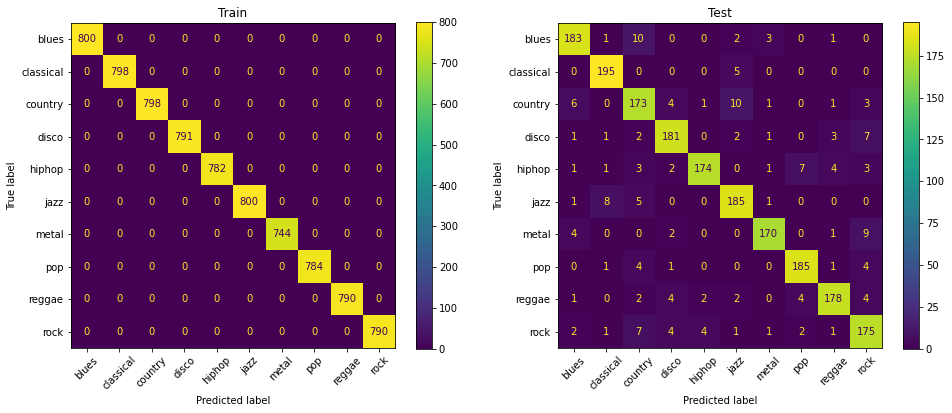

In [11]:
# confusion matrix
pred_train = lgb.predict(X_train)
pred_test = lgb.predict(X_test)
conf_matrix = confusion_matrix(y_train, pred_train)
#display(conf_matrix)

# plot confusion matrix
fig, ax = plt.subplots(1,2, figsize=(16,6))
plot_confusion_matrix(lgb, X_train, y_train, ax=ax[0], xticks_rotation=45)
plot_confusion_matrix(lgb, X_test, y_test, ax=ax[1], xticks_rotation=45)
ax[0].set_title('Train')
ax[1].set_title('Test')
plt.show()

In [14]:
class_report = classification_report(y_train, pred_train, digits=4)
print()
print('Classification report: train set')
print()
print(class_report)

class_report = classification_report(y_test, pred_test, digits=4)
print()
print('Classification report: test set')
print()
print(class_report)


Classification report: train set

              precision    recall  f1-score   support

       blues     1.0000    1.0000    1.0000       800
   classical     1.0000    1.0000    1.0000       798
     country     1.0000    1.0000    1.0000       798
       disco     1.0000    1.0000    1.0000       791
      hiphop     1.0000    1.0000    1.0000       782
        jazz     1.0000    1.0000    1.0000       800
       metal     1.0000    1.0000    1.0000       744
         pop     1.0000    1.0000    1.0000       784
      reggae     1.0000    1.0000    1.0000       790
        rock     1.0000    1.0000    1.0000       790

    accuracy                         1.0000      7877
   macro avg     1.0000    1.0000    1.0000      7877
weighted avg     1.0000    1.0000    1.0000      7877


Classification report: test set

              precision    recall  f1-score   support

       blues     0.9196    0.9150    0.9173       200
   classical     0.9375    0.9750    0.9559       200
     coun

In [21]:
lgb.feature_importances_

array([1769, 1132, 1301, 2031,  790,  787, 1593,  952,  670,  970, 1351,
        709, 2319, 1968, 3402, 2720, 1942, 1414, 1443, 1317,  801, 2071,
       1366, 2350, 1057, 1600, 1067, 1765, 1051, 1892,  983, 1551,  783,
       1860,  814, 1548,  854, 1608,  574, 1305,  644, 1349,  627, 1266,
        559, 1073,  687, 1281,  577, 1465,  630, 1260,  594, 1134,  747,
       1317,  858], dtype=int32)

In [22]:
df_featimp = pd.DataFrame(data=[X_train.columns, lgb.feature_importances_]).T
df_featimp.columns = ['feature', 'feature_importance']

df_featimp.sort_values(by='feature_importance', ascending=False)

,feature,feature_importance
14,perceptr_mean,3402
15,perceptr_var,2720
23,mfcc4_mean,2350
12,harmony_mean,2319
21,mfcc3_mean,2071
3,rms_var,2031
13,harmony_var,1968
16,tempo,1942
29,mfcc7_mean,1892
33,mfcc9_mean,1860


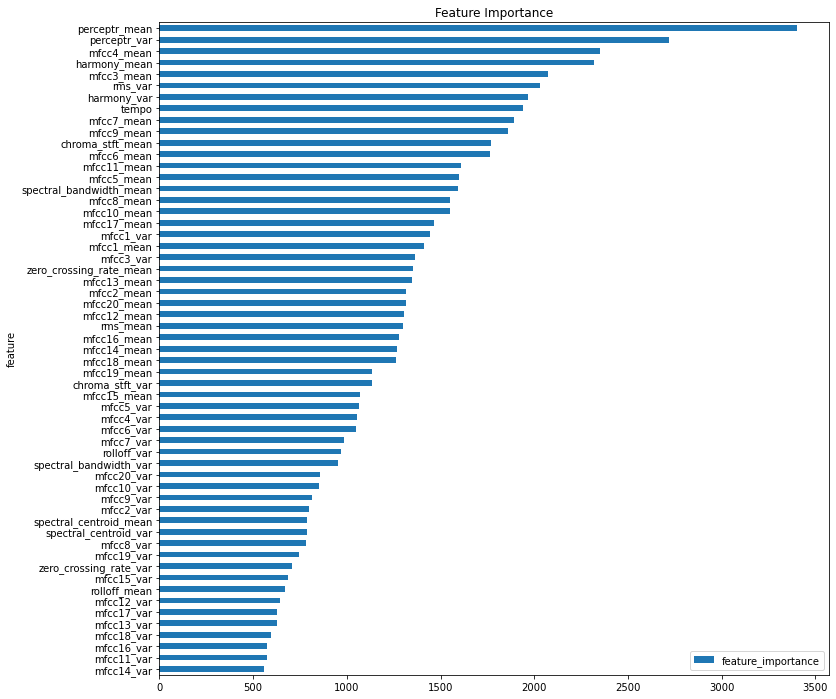

In [23]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
df_featimp.sort_values(by='feature_importance', ascending=True).plot(kind='barh', x='feature', ax=ax)
plt.title('Feature Importance')
plt.show()

# Precision - Recall

In [14]:
import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 3))

In [15]:
def plot_f1_lines(figsize=(8,6),fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)
    
    # add lines of constant F1 scores
    
    for const in np.linspace(0.2,0.9,8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                 color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                     xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

In [16]:
proba_train = lgb.predict_proba(X_train)
proba_test = lgb.predict_proba(X_test)

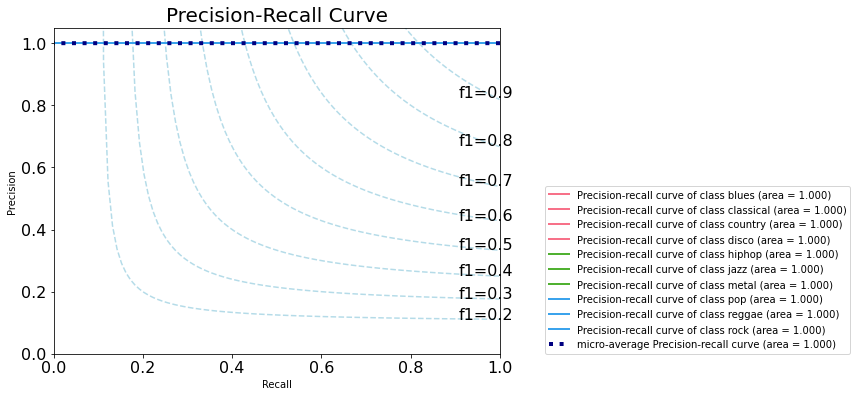

In [17]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_train, proba_train, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

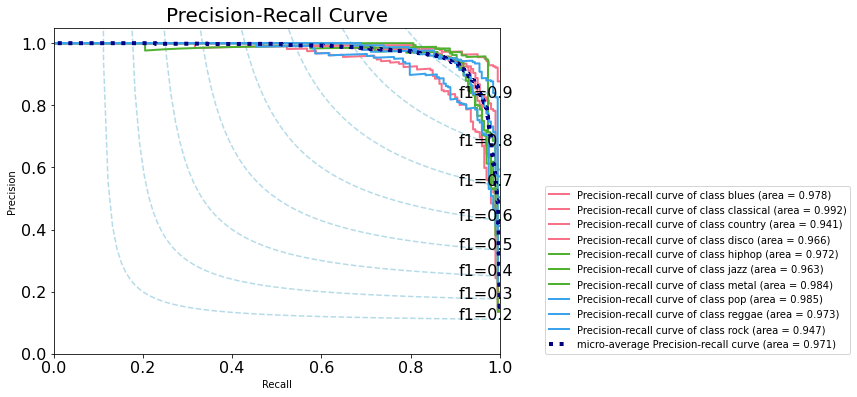

In [18]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, proba_test, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

# ROC

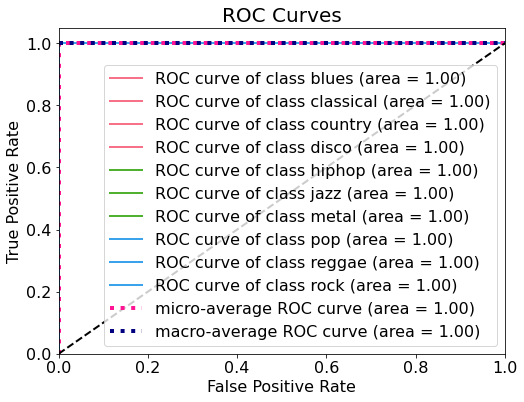

In [19]:
# ROC train
skplt.metrics.plot_roc(y_train, proba_train, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(8,6), cmap=cmap)
plt.show()

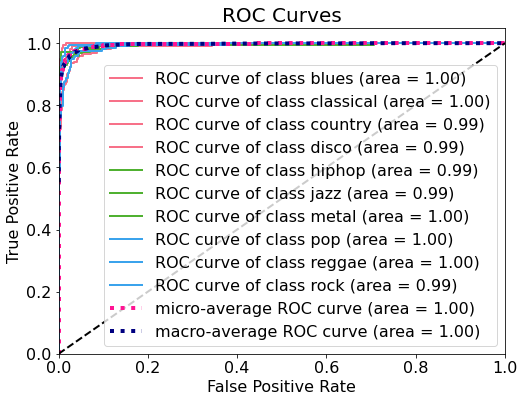

In [20]:
# ROC test
skplt.metrics.plot_roc(y_test, proba_test, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(8,6), cmap=cmap)
plt.show()

In [24]:
df_test_pred = X_test.copy()
df_test_pred['label'], df_test_pred['pred'] = y_test, lgb.predict(X_test)
df_test_pred['true_false'] = (df_test_pred.label == df_test_pred.pred)

df_test_pred.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label,pred,true_false
8122,0.006466,1.151329,-0.454924,-0.096288,-1.013039,-0.124978,-0.472557,1.576594,-0.823101,1.172676,...,0.685169,0.102035,0.433280,0.836686,1.698576,0.811672,0.855189,reggae,reggae,True
1323,-1.067772,0.241611,-1.850736,-0.762137,-1.830441,-0.939590,-1.743596,-0.996691,-1.988989,-1.049288,...,-0.941740,-0.516908,-0.830237,-0.674110,-0.465485,-0.016296,-0.759773,classical,classical,True
8394,-0.920652,0.402533,-1.376231,-0.589758,-0.413033,0.757470,-0.973097,0.008645,-0.633901,0.001642,...,-0.151185,0.337173,-0.056954,-0.279196,0.438655,-0.289404,0.486277,reggae,reggae,True
209,-0.972974,0.934979,-0.449765,0.554635,-0.860937,-0.368567,-0.603189,-0.580789,-0.836579,-0.425182,...,0.189558,0.383374,2.437225,0.846272,4.425751,0.644944,1.329055,blues,blues,True
1999,-0.116581,-0.553790,1.785218,-0.628560,0.972471,0.606618,1.367279,-0.059064,1.223867,0.352396,...,-0.489234,-0.535900,-0.376840,-0.154197,0.496323,1.063757,0.258897,country,country,True


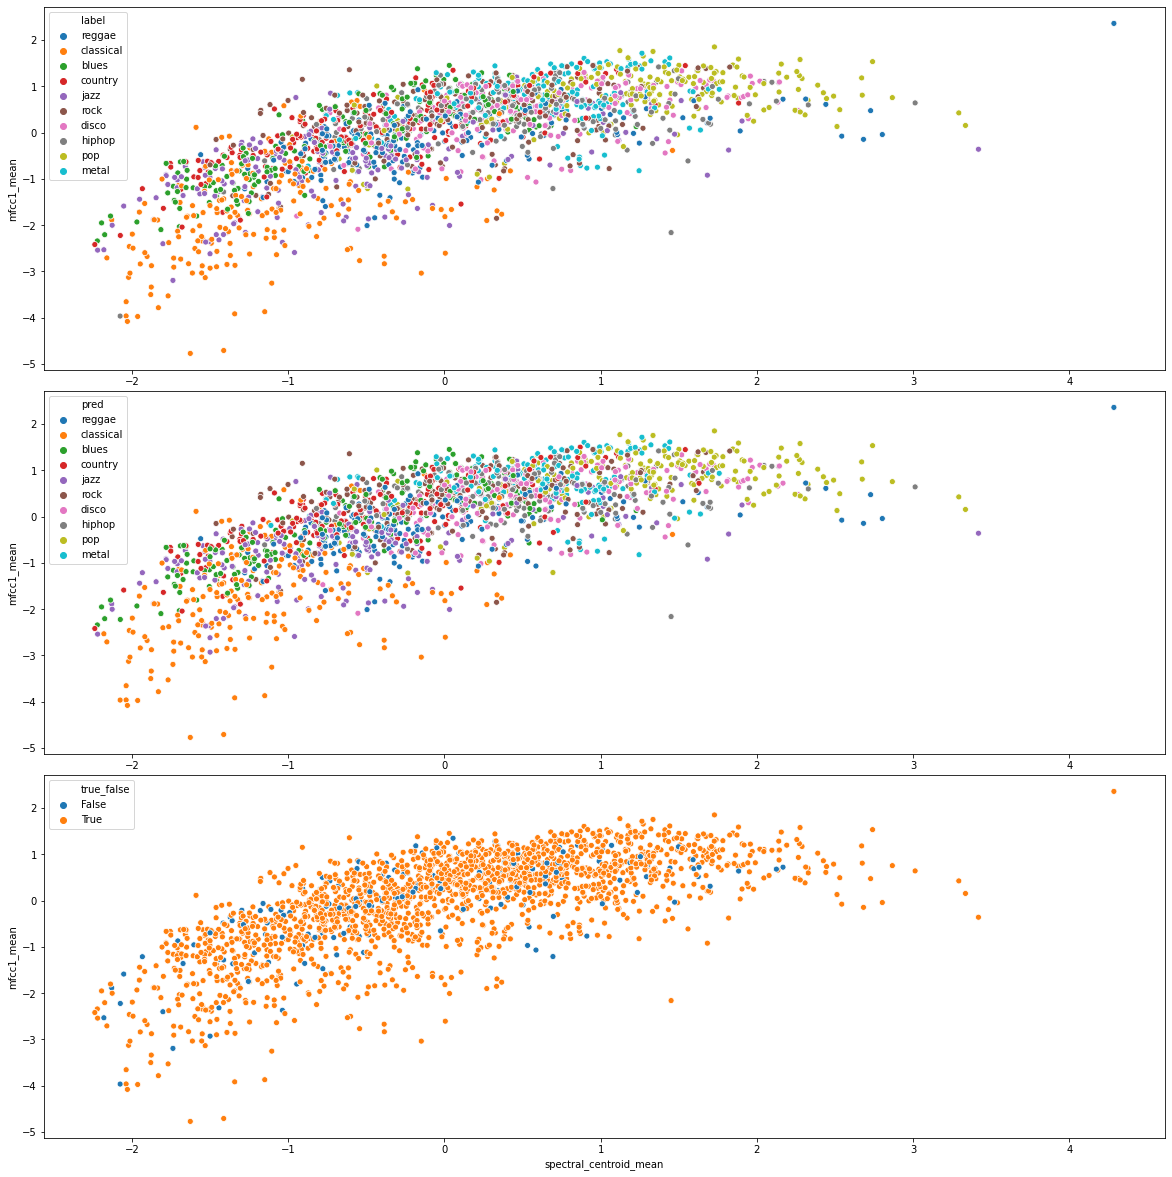

In [25]:
fig, ax = plt.subplots(3,1, figsize=(16,16))
plt.tight_layout(pad=0)

sns.scatterplot(x='spectral_centroid_mean', y='mfcc1_mean', data=df_test_pred, hue='label', ax=ax[0])
sns.scatterplot(x='spectral_centroid_mean', y='mfcc1_mean', data=df_test_pred, hue='pred', ax=ax[1])
sns.scatterplot(x='spectral_centroid_mean', y='mfcc1_mean', data=df_test_pred, hue='true_false', ax=ax[2])

# plt.xscale('log')
# plt.yscale('log')
plt.show()

LightGBM:


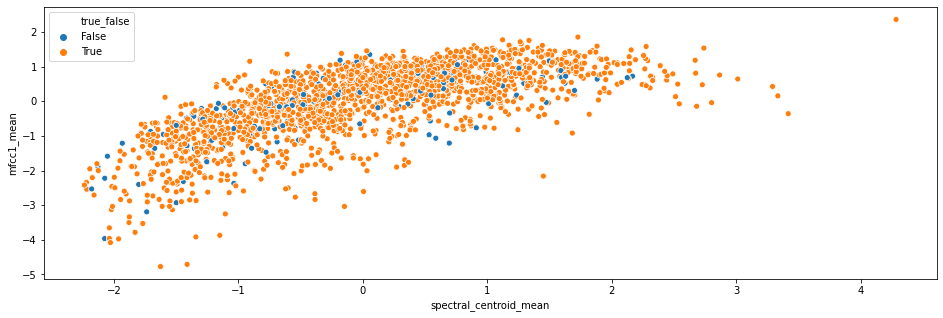

In [28]:
print('LightGBM:')

fig, ax = plt.subplots(1,1, figsize=(16,5))

sns.scatterplot(x='spectral_centroid_mean', y='mfcc1_mean', data=df_test_pred, hue='true_false', ax=ax)

# plt.xscale('log')
# plt.yscale('log')
plt.show()